# Implementing a Bernoulli Naive Bayes Classifier
In this notebook, we implement and evaluate a Naive Bayes algorithm for classification. The data will come from the 20 news groups dataset.

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, confusion_matrix
from sklearn.naive_bayes import BernoulliNB

% matplotlib inline

# 20 News Groups
The 20 newsgroups dataset comprises around 18,000 user posts on 20 topics:
- comp.graphics
- comp.os.ms-windows.misc
- comp.sys.ibm.pc.hardware
- comp.sys.mac.hardware
- comp.windows.x
- misc.forsale
- rec.autos
- rec.motorcycles
- rec.sport.baseball
- rec.sport.hockey
- talk.politics.misc
- talk.politics.guns
- talk.politics.mideast
- sci.crypt
- sci.electronics
- sci.med
- sci.space
- talk.religion.misc
- alt.atheism
- soc.religion.christian

The typical post has the following form:

In [15]:
print(data['data'][0])

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




The data is split into training and test sets, with 15076 and 3770 posts, respectively, and stratified so that the distribution of class labels between both sets is relatively even.

In [32]:
data = fetch_20newsgroups(subset='all', data_home='data/')

X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'],
                                                   test_size = 0.2,
                                                   stratify = data['target'])

print('# training examples:', len(X_train))
print('# test examples:', len(X_test))

# training examples: 15076
# test examples: 3770


Indeed, the class distribution between sets is nearly identical, and the distribution within each set is relatively even. Thus, for simplicity, we will use **accuracy** as the evaluation metric.

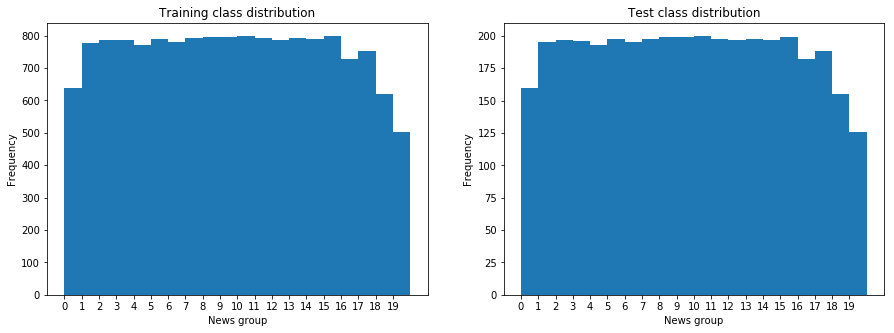

In [33]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

axes[0].hist(y_train, bins = range(21))
axes[0].set(title = 'Training class distribution')
axes[1].hist(y_test, bins = range(21))
axes[1].set(title = 'Test class distribution')

for ax in axes:
    ax.set(ylabel = 'Frequency', xlabel = 'News group')
    ax.set(xticks = range(20), xticklabels = range(20))

Finally, we vectorize the text data so that each message is represented as a sparse binary vector in $\mathcal{X} := \{0,1\}^d$ where $d$ is the number of unique words in the vocabulary. Because we do not want the classifier to overfit on words that appear rarely nor do we want common words to contribute too much noise to the model, we exclude all words that appear in less than 30 messages or more than 500 messages, resulting in $d = 7637$.

In [34]:
count = CountVectorizer(binary=True, lowercase=True, max_df=500, min_df=30)

X_train = count.fit_transform(X_train)
X_test = count.transform(X_test)
groups = train['target_names']

print('# dimensions:', X_train.shape[1])

# dimensions: 7637


# Bernoulli Naive Bayes Classifier
We develop a classifier based on the Naive Bayes generative model using class conditional distributions of the form $$P_{\mu}(x) = \prod_{j=1}^d \mu_j^{x_j}(1 - \mu_j)^{1 - x_j}$$
for $x = (x_1, x_2, ..., x_d) \in \mathcal{X}$ and some parameter vector $\mu = (\mu_1, \mu_2, ..., \mu_d) \in [0,1]^d$. $\mu_j$ is the probability that word $j$ appears in a message. Since there are $20$ classes, the generative model is actually parametrerized by $20$ such vectors, $\mu_y = (\mu_{y,1}, \mu_{y,2}, ..., \mu_{y,d})$ for each $y \in \mathcal{Y}$, as well as the class prior parameters $\pi_y \in [0,1]$ for each $y \in \mathcal{Y}$ and $\sum_{y \in \mathcal{Y}}\pi_y = 1$.

Because the MLE is not a good estimator for the class conditional parameters if the estimate turns out to eb zero or one, we use an alternative to the MLE based on *Laplace smoothing*. The probabiliy word $j$ is present in a message given the message is of class $y$ is:
$$\hat{\mu}_{y,j} := \frac{\alpha+\sum_{i=1}^n \mathbb{1}\{y_i = y\}x_{i,j}}{2\alpha + \sum_{i=1}^n\mathbb{1}\{y_i = y\}}$$

Because class conditional probabilities are exceedingly small when the number of features is large, as it is with text classification, we use log probabilities instead.

In [35]:
class BernoulliNaiveBayes:
    
    n_classes = None # number of unique labels (n)
    n_features = None # dimensionality of feature space (d)
    log_class_conditional_positive = None # n x d matrix of conditional probabilities
    log_class_conditional_negative = None # n x d matrix of conditional probabilities
    log_class_prior = None # n-dimensional vector
    alpha = None # smoothing parameter
    
    def __init__(self, alpha = 1):
        self.alpha = alpha
        return
    
    def fit(self, X, y):
        
        # count number of occurrences for each label
        y_counts = np.unique(y, return_counts=True)[1]
        
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        
        # calculate P(y), the probability of observing any message of class y
        class_prior = y_counts / y_counts.sum()
        self.log_class_prior = np.expand_dims(np.log(class_prior), axis = 1)
        
        # calculate P(x|y), the probability of observing message x given it is class y
        prob_x_given_y = np.zeros([self.n_classes, self.n_features])
        
        # for each class of y
        for i in range(self.n_classes):
            
            # select only rows of class y
            row_mask = (y == i) 
            X_filtered = X[row_mask, :]
            
            # get number of messages of each word appears in ( P(x and y) )
            numerator = (X_filtered.sum(axis = 0) + self.alpha)
            
            # get number messages in class y (scalar) ( P(y) )
            denominator = (X_filtered.shape[0] + 2 * self.alpha)
            
            # P(x|y) = P(x and y) / P(y)
            prob_x_given_y[i, :] = numerator / denominator
            
        # Calculate log probabilities for P(x|y) and P(~x|y)
        self.log_class_conditional_positive = np.log(prob_x_given_y) # k x n matrix
        self.log_class_conditional_negative = np.log(1 - prob_x_given_y) # k x n matrix
            
    def predict(self, X):
        
        X = X.todense() # m x d matrix
        
        # log P(y|x) is proportional to log P(x|y) + log P(y)
        # each n x 1 column vector is contains a value proportional to P(y|x)
        # for every possible class of y
        log_probs_positive = self.log_class_conditional_positive.dot(X.T) # n x m matrix
        log_probs_negative = self.log_class_conditional_negative.dot(1 - X.T) # n x m matrix        
        log_likelihoods = log_probs_positive + log_probs_negative # n x m matrix
        log_joint_likelihoods = log_likelihoods + self.log_class_prior # n x m matrix
        
        # for each column vector, find class y that maximizes P(y|x)
        preds = np.argmax(log_joint_likelihoods, axis = 0) # 1 x m matrix
        preds = np.array(preds).squeeze() # m-dimensional vector
        return preds

Training and evaluating the above model on the train and test sets, respectively, we achieve a good classification accuracy of **0.814**.

In [49]:
bnb = BernoulliNaiveBayes(alpha = 0.001)
bnb.fit(X_train, y_train)
y_pred = bnb.predict(X_test)
print('test accuracy:', accuracy_score(y_test, y_pred))
print('macro f1 score:', f1_score(y_test, y_pred, average='macro'))

test accuracy: 0.813793103448
macro f1 score: 0.814195556684


The confusion matrix below also shows that the classification performance is quite good. Most classification errors occur between news groups within a broader array of computer-related forums. Posts in **misc.forsale** are also likely to be confused for other groups.

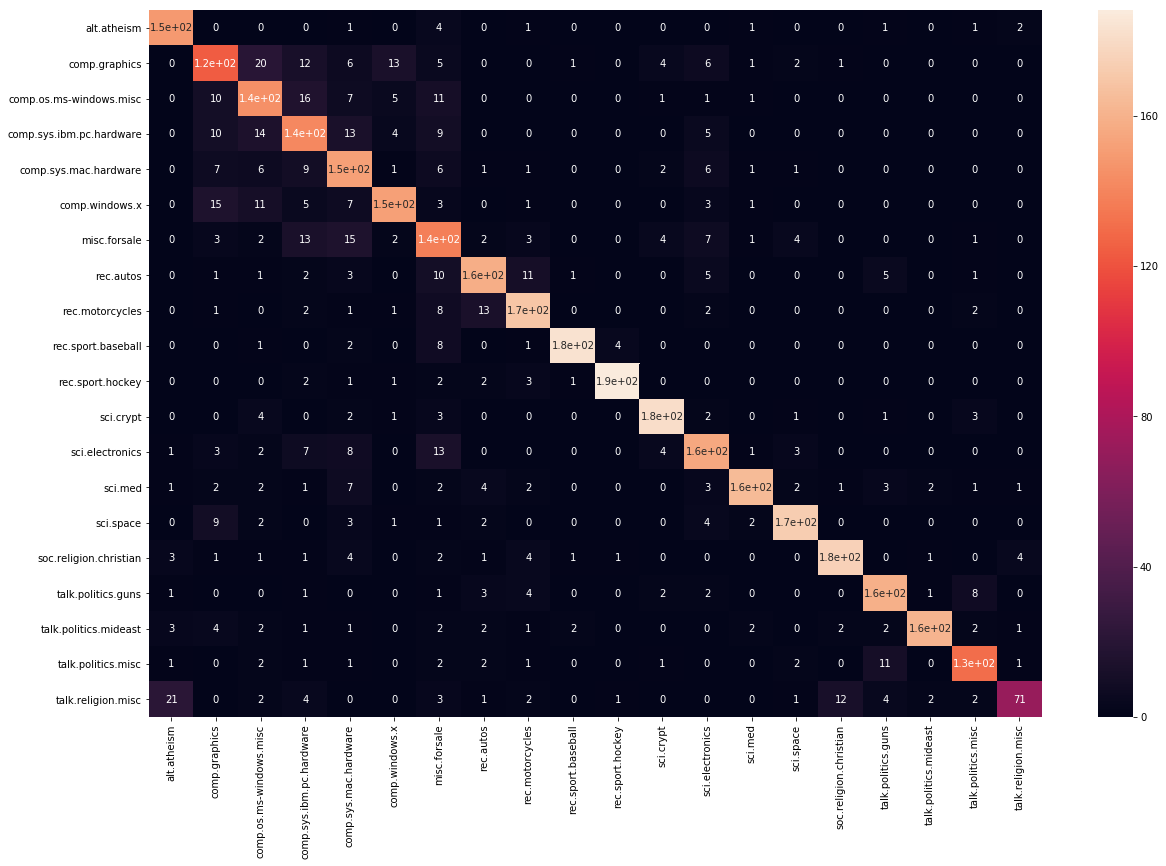

In [61]:
conf = confusion_matrix(y_test, y_pred)
conf = pd.DataFrame(conf, columns = groups, index = groups)

plt.figure(figsize = (20,13))
sns.heatmap(conf, annot = True)

The classifier learned above has the following form: $$x \rightarrow \arg\max_{y \in \mathcal{Y}} \alpha_{y, 0} + \sum_{j=1}^d \alpha_{y,j}x_j$$

for some real numbers $\alpha_{y, 0}, \alpha_{y,1}, ..., \alpha_{y,d}$ for each $y \in \mathcal{Y}$. For each class $y \in \mathcal{Y}$, we report the vocabulary words whose indices $j \in \{1,2,...,d\}$ correspond to the $20$ largest $\alpha_{y,j}$ values. In other words, for each news group, we report the terms whose presence most strongly indicate a message is of that class.

In [69]:
params = bnb.log_class_conditional_positive
ind = params.argsort(axis = 1)[:,-20:]
vocabulary = {v: k for k, v in count.vocabulary_.items()}

for i in range(ind.shape[0]):
    print(str.upper(groups[i]))
    print('===')
    for j in range(ind.shape[1]):
        print(vocabulary[ind[i][j]], end = ' ')
    print('\n')

ALT.ATHEISM
===
wpd livesey jon bible sgi allan islamic argument schneider religious atheist caltech political cco moral morality atheism religion keith atheists 

COMP.GRAPHICS
===
project animation algorithm fast vga library display convert screen package video programs comp gif color format ftp 3d images image 

COMP.OS.MS-WINDOWS.MISC
===
supporters printer challenge mode application user screen applications cica video directory window disk manager os drivers ftp driver microsoft ms 

COMP.SYS.IBM.PC.HARDWARE
===
drivers gateway mode video port floppy isa cards bios monitor hardware motherboard 486 scsi drives ide board disk bus controller 

COMP.SYS.MAC.HARDWARE
===
internal drives monitors upgrade macintosh ii machines iisi lc se powerbook board disk scsi video ram quadra hardware centris monitor 

COMP.WINDOWS.X
===
error create text color screen xterm xpert widget x11 manager expo user x11r5 display lcs server application motif mit window 

MISC.FORSALE
===
model ii disk monito